# Test sample_quality.py functions

In [82]:
from scipy.stats import multivariate_normal as mvn
import numpy as np
import matplotlib.pyplot as plt

import sample_quality as sq
import functions as fn

import importlib
importlib.reload(sq)
# https://www.geeksforgeeks.org/reloading-modules-python/

<module 'sample_quality' from 'C:\\Users\\hechu\\Documents\\GitHub\\MClib\\MCLibPy\\sample_quality.py'>

## Measures

### ESS

$$ESS = \sum_{m}\frac{1}{{w^{(m)}}^2}$$
ESS is between 1 and N. We can devide it by N to normalize ESS over sample size

$$\frac{ESS}{N} = \frac{1}{N} \sum_{m}\frac{1}{{w^{(m)}}^2}$$

### KLD
The paricles can be written as a pdf constructed by a group of weighted delta functions:
$$\pi'(x)=\sum_m w^{(m)}\delta(x-x^{(m)})$$
Then,
$$\begin{array}{l}
D_{\mathrm{KL}} \left(\pi \left(x\right)||\pi^{\prime } \left(x\right)\right)=\int \pi \left(x\right)\left\lbrack \mathrm{log}\left(\pi \left(x\right)\right)-\mathrm{log}\left(\sum_m w^{\left(m\right)} \delta \left(x-x^{\left(m\right)} \right)\right)\right\rbrack \\
=\int \pi \left(x\right)\mathrm{log}\left(\pi \left(x\right)\right)\mathit{dx}-\int \pi \left(x\right)\mathrm{log}\left(\sum_m w^{\left(m\right)} \delta \left(x-x^{\left(m\right)} \right)\right)\mathit{dx}\\
=\mathrm{constant}-\sum_m \int \pi \left(x\right)\mathrm{log}\left(w^{\left(m\right)} \right)\delta \left(x-x^{\left(m\right)} \right)\;\mathit{dx}\\
=\mathrm{constant}-\sum_m \pi \left(x^{\left(m\right)} \right)\mathrm{log}\left(w^{\left(m\right)} \right)
\end{array}$$
If target distribution is fixed, we only need to compare
$$ -\sum_m \pi \left(x^{\left(m\right)} \right)\mathrm{log}\left(w^{\left(m\right)} \right)$$

## Quality vs shift

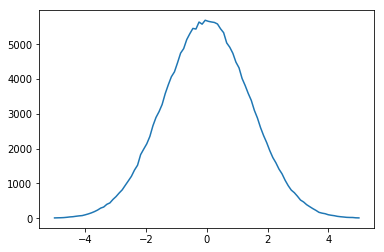

-610.4062050794942
5622.048913948439


In [92]:
# globals
D = 2
N = 10000

# define target function
pi = lambda x: mvn.pdf(x, mean=0*np.ones(shape=D),cov=np.eye(D))

# define sampling process
def sample(tau):
    mu = np.ones(shape=D)
    mu[0] = tau
    x = mvn.rvs(mean=mu, cov=np.eye(D),size=N)
    return x
    

# define containers
KLD_log = []
tau = np.linspace(-5.0,5.0,100)
for i in range(len(tau)):
    x = sample(tau[i])
    KLD_log.append(sq.KLD(x, pi))
plt.figure()
plt.plot(tau, KLD_log)
plt.show()
x=sample(0)
print(-np.sum(pi(x)))
print(sq.KLD(x,pi))